In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve,
    precision_score, recall_score, f1_score
)

# Detect Colab
IN_COLAB = 'google.colab' in sys.modules
print("Running in Colab" if IN_COLAB else "Running locally")


Running in Colab


In [4]:
filename = '/content/creditcard.csv'  # set to your actual path
import pandas as pd
transactions = pd.read_csv(filename)
print('Loaded:', filename, 'Shape:', transactions.shape)


Loaded: /content/creditcard.csv Shape: (284807, 31)


In [5]:
transactions = pd.read_csv(filename)
print(f"✅ Loaded dataset from: {filename}")
print(transactions.shape)


✅ Loaded dataset from: /content/creditcard.csv
(284807, 31)


Dataset Shape: (284807, 31)

Basic Statistics:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-1

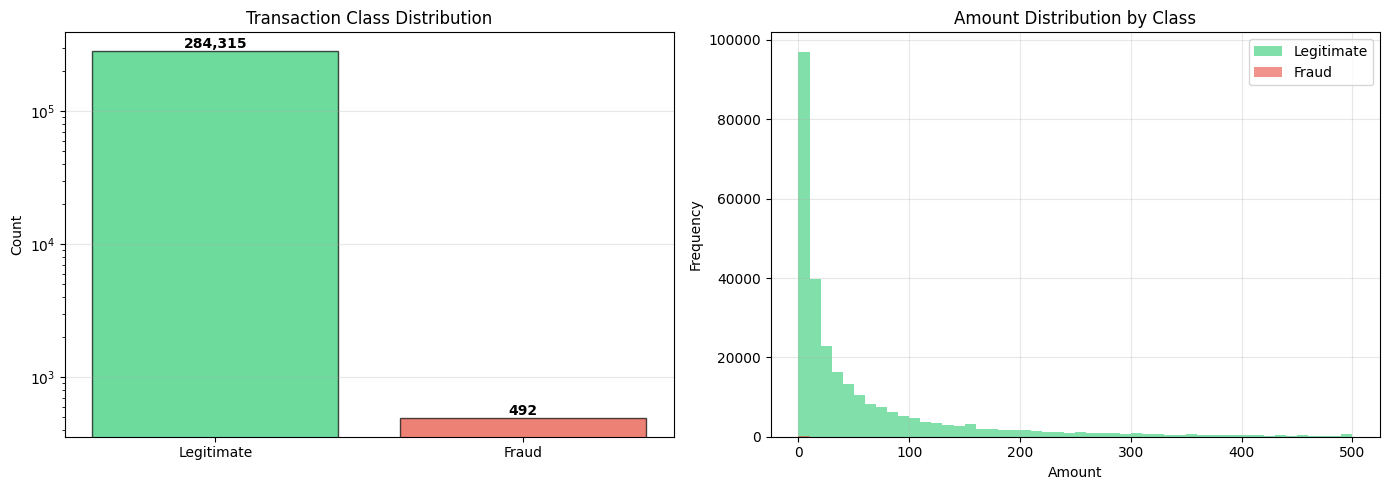


Fraud Transaction Statistics:
Mean Amount: $122.21
Median Amount: $9.25
Max Amount: $2125.87


In [6]:
print(f"Dataset Shape: {transactions.shape}")
print("\nBasic Statistics:")
print(transactions.describe())

fraud_count = transactions['Class'].value_counts()
legit, fraud = fraud_count[0], fraud_count[1]
print("\n=== Class Distribution ===")
print(f"Legitimate: {legit:,} ({legit/len(transactions)*100:.2f}%)")
print(f"Fraud: {fraud:,} ({fraud/len(transactions)*100:.4f}%)")
print(f"Imbalance Ratio: {legit/fraud:.1f}:1")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution (log scale to show both clearly)
ax[0].bar(['Legitimate', 'Fraud'], [legit, fraud], color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax[0].set_yscale('log')
ax[0].set_ylabel('Count')
ax[0].set_title('Transaction Class Distribution', fontsize=12)
ax[0].grid(axis='y', alpha=0.3)
for i, count in enumerate([legit, fraud]):
    ax[0].text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Amount distribution by class (clipped to 0-500 for visibility)
transactions_fraud = transactions[transactions['Class'] == 1]
transactions_legit = transactions[transactions['Class'] == 0]
ax[1].hist(transactions_legit['Amount'], bins=50, alpha=0.6, label='Legitimate', color='#2ecc71', range=(0, 500))
ax[1].hist(transactions_fraud['Amount'], bins=50, alpha=0.6, label='Fraud', color='#e74c3c', range=(0, 500))
ax[1].set_xlabel('Amount')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Amount Distribution by Class', fontsize=12)
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFraud Transaction Statistics:")
print(f"Mean Amount: ${transactions_fraud['Amount'].mean():.2f}")
print(f"Median Amount: ${transactions_fraud['Amount'].median():.2f}")
print(f"Max Amount: ${transactions_fraud['Amount'].max():.2f}")


In [7]:
missing_summary = transactions.isna().sum()
missing_summary[missing_summary > 0]


,0


In [8]:
# Keep splits stratified due to extreme imbalance
train_val, test = train_test_split(
    transactions, test_size=0.2, stratify=transactions['Class'], random_state=42
)
train, valid = train_test_split(
    train_val, test_size=0.25, stratify=train_val['Class'], random_state=42
)

train.shape, valid.shape, test.shape


((170883, 31), (56962, 31), (56962, 31))

In [9]:
# Standardize Amount and Time; keep originals for reference if needed
scaler_amount = StandardScaler()
scaler_time = StandardScaler()

for frame in (train, valid, test):
    if frame is train:
        frame['scaled_amount'] = scaler_amount.fit_transform(frame[['Amount']])
        frame['scaled_time'] = scaler_time.fit_transform(frame[['Time']])
    else:
        frame['scaled_amount'] = scaler_amount.transform(frame[['Amount']])
        frame['scaled_time'] = scaler_time.transform(frame[['Time']])


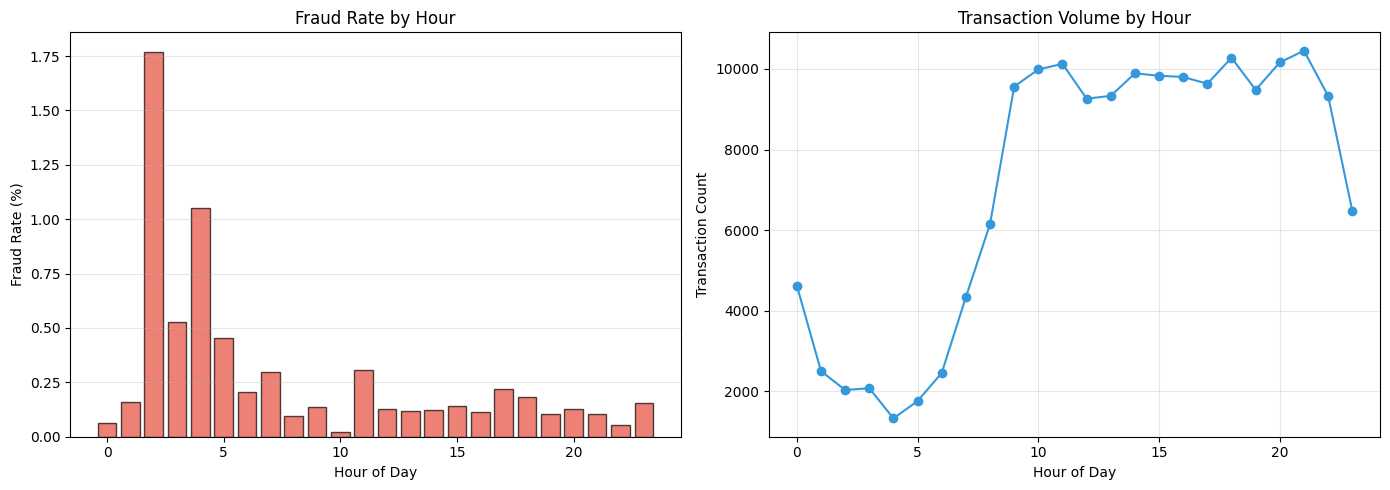

In [10]:
# Create hour feature from Time (seconds since first transaction)
for frame in (train, valid, test):
    frame['hour'] = ((frame['Time'] // 3600) % 24).astype(int)

# Temporal analysis (optional)
fraud_by_hour = train.groupby(['hour', 'Class']).size().unstack(fill_value=0)
fraud_rate_by_hour = (fraud_by_hour[1] / fraud_by_hour.sum(axis=1) * 100)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].bar(fraud_rate_by_hour.index, fraud_rate_by_hour.values, color='#e74c3c', alpha=0.7, edgecolor='black')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Fraud Rate (%)')
ax[0].set_title('Fraud Rate by Hour', fontsize=12)
ax[0].grid(axis='y', alpha=0.3)

tx_by_hour = train.groupby('hour').size()
ax[1].plot(tx_by_hour.index, tx_by_hour.values, marker='o', color='#3498db')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Transaction Count')
ax[1].set_title('Transaction Volume by Hour', fontsize=12)
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
# Use PCA-like V1..V28, scaled_amount, scaled_time; exclude leak-prone and target
exclude = {'Class', 'Time', 'Amount'}
features = [c for c in train.columns if c not in exclude]
X_train, y_train = train[features], train['Class']
X_valid, y_valid = valid[features], valid['Class']
X_test,  y_test  = test[features],  test['Class']

len(features), features[:8]


(31, ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8'])

In [12]:
weighted_logreg = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=None)
weighted_logreg.fit(X_train, y_train)
valid_scores = weighted_logreg.predict_proba(X_valid)[:, 1]
print('LogReg ROC-AUC:', roc_auc_score(y_valid, valid_scores))
print('LogReg AUPRC:', average_precision_score(y_valid, valid_scores))


LogReg ROC-AUC: 0.9790211703230713
LogReg AUPRC: 0.674175583277371


In [13]:
iso_forest = IsolationForest(contamination=0.001, random_state=42)
iso_forest.fit(X_train)
# Convert anomaly score: higher means more anomalous
valid_anomaly = -iso_forest.score_samples(X_valid)
print('IsolationForest ROC-AUC:', roc_auc_score(y_valid, valid_anomaly))
print('IsolationForest AUPRC:', average_precision_score(y_valid, valid_anomaly))


IsolationForest ROC-AUC: 0.9440668756040791
IsolationForest AUPRC: 0.13602175391254326


In [14]:
rf = RandomForestClassifier(
    n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)
rf_valid_scores = rf.predict_proba(X_valid)[:, 1]
print('RandomForest ROC-AUC:', roc_auc_score(y_valid, rf_valid_scores))
print('RandomForest AUPRC:', average_precision_score(y_valid, rf_valid_scores))

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
gb_valid_scores = gb.predict_proba(X_valid)[:, 1]
print('GradientBoosting ROC-AUC:', roc_auc_score(y_valid, gb_valid_scores))
print('GradientBoosting AUPRC:', average_precision_score(y_valid, gb_valid_scores))


RandomForest ROC-AUC: 0.9510137514639563
RandomForest AUPRC: 0.8079694770091866
GradientBoosting ROC-AUC: 0.7826592605974629
GradientBoosting AUPRC: 0.5752638608286634


In [15]:
# If needed locally: pip install xgboost
try:
    from xgboost import XGBClassifier
    xgb_model = XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    xgb_valid_scores = xgb_model.predict_proba(X_valid)[:, 1]
    print('XGBoost ROC-AUC:', roc_auc_score(y_valid, xgb_valid_scores))
    print('XGBoost AUPRC:', average_precision_score(y_valid, xgb_valid_scores))
except Exception as e:
    print("XGBoost unavailable or failed to import/train. Skipping. Error:", e)
    xgb_model = None
    xgb_valid_scores = None


XGBoost ROC-AUC: 0.9725700811644219
XGBoost AUPRC: 0.8071571424281719


In [16]:
models_results = {
    'Logistic Regression': valid_scores,
    'Isolation Forest': valid_anomaly,
    'Random Forest': rf_valid_scores,
    'Gradient Boosting': gb_valid_scores
}
if xgb_valid_scores is not None:
    models_results['XGBoost'] = xgb_valid_scores

comparison_rows = []
for name, scores in models_results.items():
    comparison_rows.append({
        'Model': name,
        'ROC-AUC': roc_auc_score(y_valid, scores),
        'AUPRC': average_precision_score(y_valid, scores)
    })
comparison_df = pd.DataFrame(comparison_rows).sort_values('AUPRC', ascending=False)
print('=== Model Performance Comparison (Validation) ===')
print(comparison_df.to_string(index=False))

# Pick champion by AUPRC
champion_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 Champion Model: {champion_name}")
champion_scores = models_results[champion_name]


=== Model Performance Comparison (Validation) ===
              Model  ROC-AUC    AUPRC
      Random Forest 0.951014 0.807969
            XGBoost 0.972570 0.807157
Logistic Regression 0.979021 0.674176
  Gradient Boosting 0.782659 0.575264
   Isolation Forest 0.944067 0.136022

🏆 Champion Model: Random Forest


=== Cost-Sensitive Threshold Optimization ===
Optimal Threshold: 0.030
Minimum Expected Cost: $4,540.00
Precision: 0.562 | Recall: 0.828 | F1: 0.669


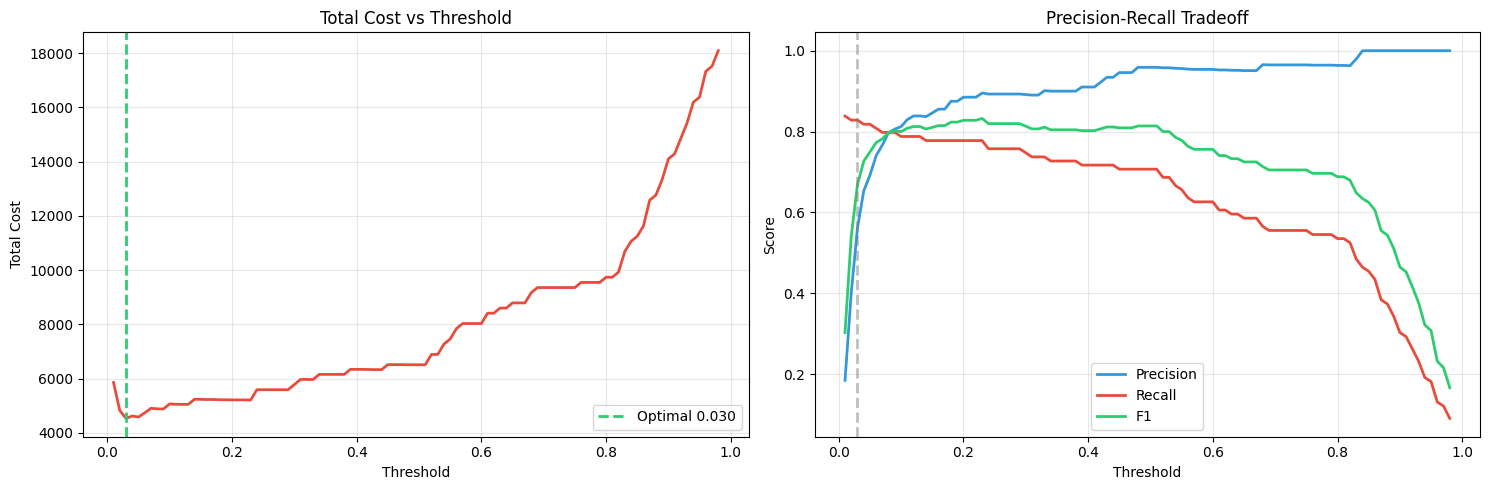

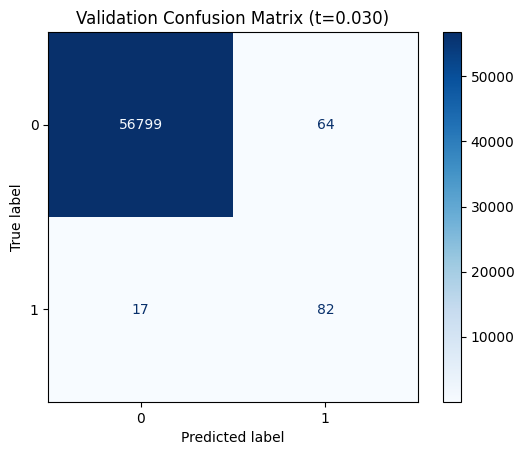

In [17]:
# Business cost parameters (example)
cost_false_positive = 5
cost_false_negative = 200
cost_true_positive = 10

thresholds = np.arange(0.01, 0.99, 0.01)
costs = []
metrics_by_threshold = []

for t in thresholds:
    preds = (champion_scores >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_valid, preds).ravel()
    total_cost = fp * cost_false_positive + fn * cost_false_negative + tp * cost_true_positive
    costs.append(total_cost)
    metrics_by_threshold.append({
        'threshold': t,
        'total_cost': total_cost,
        'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
        'precision': precision_score(y_valid, preds, zero_division=0),
        'recall': recall_score(y_valid, preds, zero_division=0),
        'f1': f1_score(y_valid, preds, zero_division=0),
    })

optimal_idx = int(np.argmin(costs))
optimal = metrics_by_threshold[optimal_idx]
optimal_threshold = optimal['threshold']
print('=== Cost-Sensitive Threshold Optimization ===')
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Minimum Expected Cost: ${optimal['total_cost']:,.2f}")
print(f"Precision: {optimal['precision']:.3f} | Recall: {optimal['recall']:.3f} | F1: {optimal['f1']:.3f}")

# Curves
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(thresholds, costs, color='#e74c3c', linewidth=2)
ax[0].axvline(optimal_threshold, color='#2ecc71', linestyle='--', linewidth=2, label=f'Optimal {optimal_threshold:.3f}')
ax[0].set_title('Total Cost vs Threshold')
ax[0].set_xlabel('Threshold'); ax[0].set_ylabel('Total Cost'); ax[0].legend(); ax[0].grid(alpha=0.3)

mdf = pd.DataFrame(metrics_by_threshold)
ax[1].plot(mdf['threshold'], mdf['precision'], label='Precision', color='#3498db', linewidth=2)
ax[1].plot(mdf['threshold'], mdf['recall'], label='Recall', color='#e74c3c', linewidth=2)
ax[1].plot(mdf['threshold'], mdf['f1'], label='F1', color='#2ecc71', linewidth=2)
ax[1].axvline(optimal_threshold, color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax[1].set_title('Precision-Recall Tradeoff')
ax[1].set_xlabel('Threshold'); ax[1].set_ylabel('Score'); ax[1].legend(); ax[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

# Confusion matrix at optimal threshold
optimal_valid_preds = (champion_scores >= optimal_threshold).astype(int)
ConfusionMatrixDisplay.from_predictions(y_valid, optimal_valid_preds, cmap='Blues')
plt.title(f'Validation Confusion Matrix (t={optimal_threshold:.3f})')
plt.show()


=== Final Test Performance ===
ROC-AUC: 0.9616
AUPRC: 0.8601

Classification Report (optimal threshold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.49      0.89      0.63        98

    accuracy                           1.00     56962
   macro avg       0.74      0.94      0.81     56962
weighted avg       1.00      1.00      1.00     56962


Business Cost (Test): $3,530.00
Fraud Detection Rate: 88.8%
False Alarm Rate: 0.16%


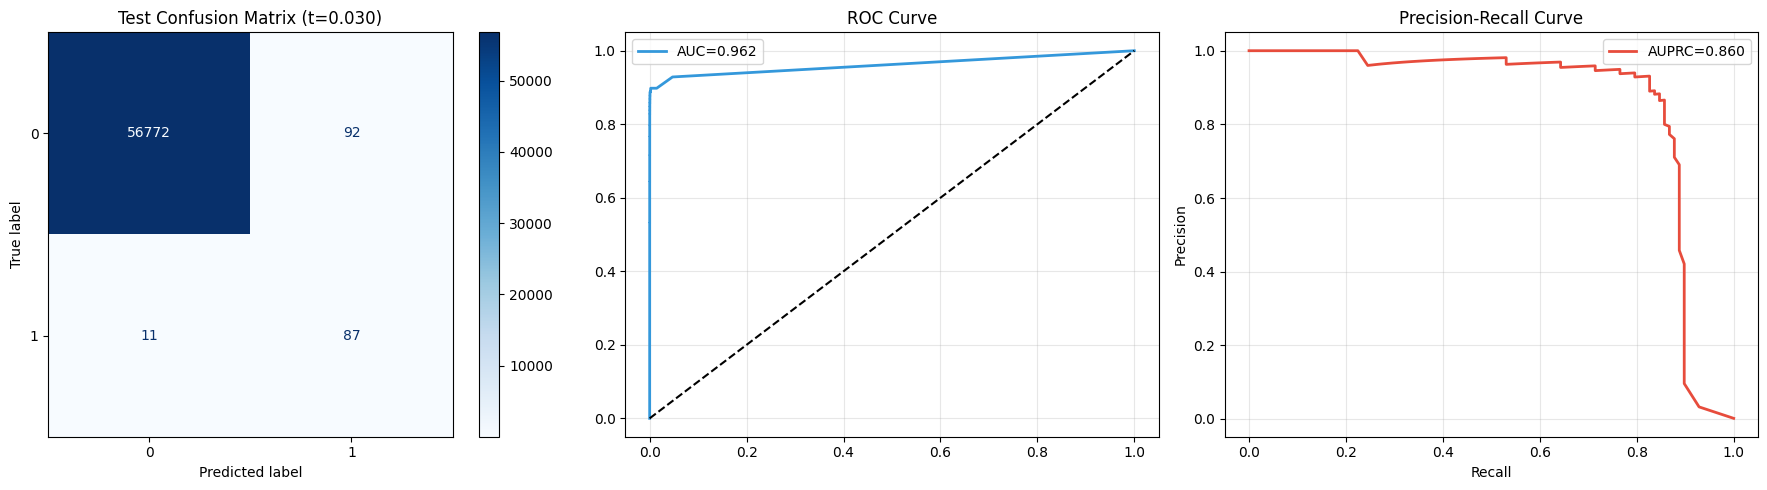

In [18]:
# Scores from champion model on test set
def predict_scores(model_name):
    if model_name == 'Logistic Regression':
        return weighted_logreg.predict_proba(X_test)[:, 1]
    if model_name == 'Random Forest':
        return rf.predict_proba(X_test)[:, 1]
    if model_name == 'Gradient Boosting':
        return gb.predict_proba(X_test)[:, 1]
    if model_name == 'XGBoost' and xgb_model is not None:
        return xgb_model.predict_proba(X_test)[:, 1]
    if model_name == 'Isolation Forest':
        return -iso_forest.score_samples(X_test)
    raise ValueError(f"Unknown champion {model_name}")

test_scores_champion = predict_scores(champion_name)
test_preds_optimal = (test_scores_champion >= optimal_threshold).astype(int)

print('=== Final Test Performance ===')
print(f'ROC-AUC: {roc_auc_score(y_test, test_scores_champion):.4f}')
print(f'AUPRC: {average_precision_score(y_test, test_scores_champion):.4f}')
print('\nClassification Report (optimal threshold):')
print(classification_report(y_test, test_preds_optimal))

cm_test = confusion_matrix(y_test, test_preds_optimal)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
test_total_cost = fp_test * cost_false_positive + fn_test * cost_false_negative + tp_test * cost_true_positive
print(f'\nBusiness Cost (Test): ${test_total_cost:,.2f}')
print(f'Fraud Detection Rate: {tp_test/(tp_test+fn_test+1e-12)*100:.1f}%')
print(f'False Alarm Rate: {fp_test/(fp_test+tn_test+1e-12)*100:.2f}%')

# Curves
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_optimal, ax=ax[0], cmap='Blues')
ax[0].set_title(f'Test Confusion Matrix (t={optimal_threshold:.3f})')

fpr, tpr, _ = roc_curve(y_test, test_scores_champion)
ax[1].plot(fpr, tpr, color='#3498db', linewidth=2, label=f"AUC={roc_auc_score(y_test, test_scores_champion):.3f}")
ax[1].plot([0,1],[0,1],'k--'); ax[1].legend(); ax[1].set_title('ROC Curve'); ax[1].grid(alpha=0.3)

prec, rec, _ = precision_recall_curve(y_test, test_scores_champion)
ax[2].plot(rec, prec, color='#e74c3c', linewidth=2, label=f"AUPRC={average_precision_score(y_test, test_scores_champion):.3f}")
ax[2].set_xlabel('Recall'); ax[2].set_ylabel('Precision'); ax[2].set_title('Precision-Recall Curve'); ax[2].legend(); ax[2].grid(alpha=0.3)
plt.tight_layout(); plt.show()


In [19]:
from joblib import dump

artifacts = Path('../app/artifacts')
artifacts.mkdir(parents=True, exist_ok=True)

# Save champion model and metadata
if champion_name == 'Logistic Regression':
    dump(weighted_logreg, artifacts / 'credit_fraud_model.joblib')
elif champion_name == 'Random Forest':
    dump(rf, artifacts / 'credit_fraud_model.joblib')
elif champion_name == 'Gradient Boosting':
    dump(gb, artifacts / 'credit_fraud_model.joblib')
elif champion_name == 'XGBoost' and xgb_model is not None:
    dump(xgb_model, artifacts / 'credit_fraud_model.joblib')
else:
    dump(iso_forest, artifacts / 'credit_fraud_model.joblib')

dump(features, artifacts / 'feature_order.joblib')
dump({'optimal_threshold': float(optimal_threshold)}, artifacts / 'threshold_config.joblib')

print(f"✓ Saved model, feature order, and optimal threshold to {artifacts}")


✓ Saved model, feature order, and optimal threshold to ../app/artifacts
